In [73]:
%config Conpleter.use_jedi = False

# 의사결정나무

콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를
이용하여 예측값을 구하라.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import pydotplus
import warnings
warnings.filterwarnings('ignore')

ssrc = graphviz.Source(dot_graph)

src.view()

=> 그래프 출력하는 코드 밑에 이 코드를 출력하면 pdf로 저장해서 그림 쉽게 비교 가능!

In [2]:
df_raw = pd.read_csv("Concrete.csv", encoding = 'euc-kr')
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength",axis = 1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.4,
                                                                random_state=1234)
print("train dzta X size : {}".format(df_train_x.shape))
print("train dzta Y size : {}".format(df_train_y.shape))
print("test dzta X size : {}".format(df_test_x.shape))
print("test dzta Y size : {}".format(df_test_y.shape))

train dzta X size : (618, 8)
train dzta Y size : (618,)
test dzta X size : (412, 8)
test dzta Y size : (412,)


In [79]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.996
Score on test set: 0.790


모델 설명력은 train 99%, test 0.79로 모델은 train에 과대적합

### 모델 파라미터 조정

* min_sample_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [4]:
train_score = []
test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234,
                                min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


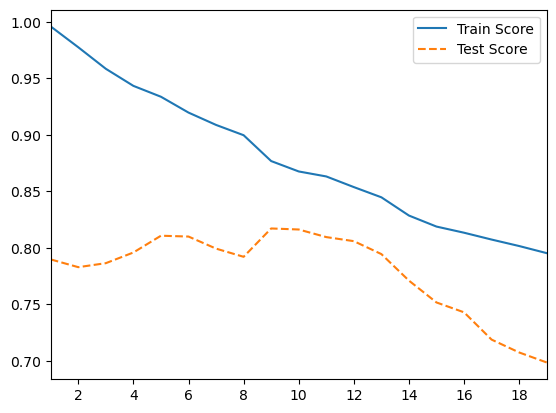

In [81]:
plt.plot(para_leaf,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_leaf,test_score,linestyle = "--",label = "Test Score")
plt.legend()

- 잎사귀 노드 최소 자료 수 증가에 따라 Train모델의 설명력은 감소

- train/test 데이터의 성능 변화를 고려했을 때  Test score가 5에서 약간 위로 올라오고, 8에서 가장 높은 갚을 보인다

- 잎사귀 노드 최소 자료수가 8일 때 Train score와 test score사이 gap이 가장 작다

=> min_sample_leaf로 8 선택

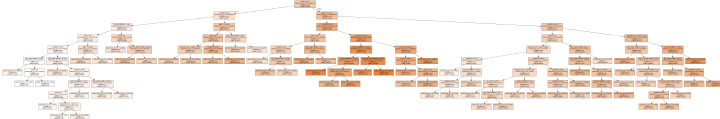

In [5]:
# 변수명 저장
v_feature_name = df_train_x.columns

#노드의 최소 자료수 = 8 모델
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=8)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_leaf.dot",
               feature_names= v_feature_name, impurity=True,filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()

fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]

display(graphviz.Source(fixed_dot_graph))

- min_sample_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [6]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8,
                                min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.900,0.792
1,6,0.900,0.792
2,8,0.900,0.792
3,10,0.900,0.792
4,12,0.900,0.792
5,14,0.900,0.792
6,16,0.900,0.792
7,18,0.887,0.798
8,20,0.882,0.802
9,22,0.874,0.802


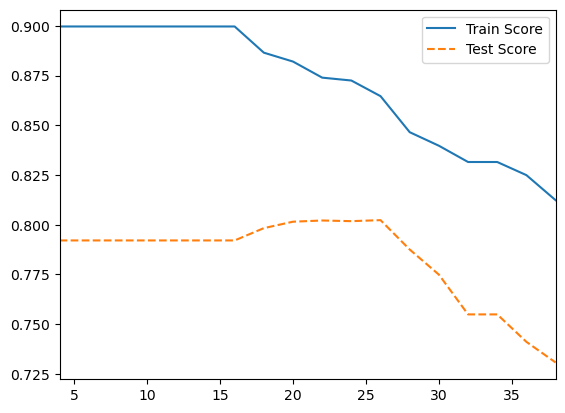

In [84]:
plt.plot(para_split,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_split,test_score,linestyle = "--",label = "Test Score")
plt.legend()

분리 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소하며 

Train/Test 데이터의 성능 변화를 고려했을 때 16에서 test가 약간 상승하고 26에서 최대가 된 뒤 급격하게 갑소한다 

=> 분리 노드의 최소 자료수 16과 26을 비교하여 적절한 값을 선택하기로 한다

* 분리 노드의 최소 자료 수 변경 결과 16 vs 26

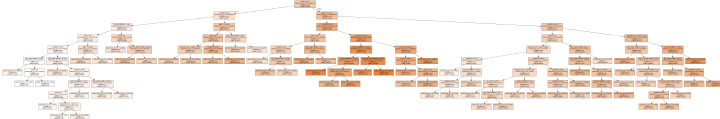

In [7]:
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=8,min_samples_split=16)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_split.dot",
               feature_names= v_feature_name, impurity=True,filled=True)
with open("tree_split.dot") as f:
    dot_graph = f.read()

fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

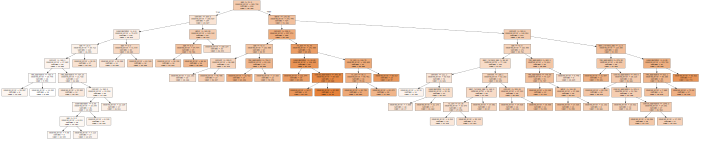

In [86]:
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=8,min_samples_split=26)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_split.dot",
               feature_names= v_feature_name, impurity=True,filled=True)
with open("tree_split.dot") as f:
    dot_graph = f.read()

fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

 분리 노드의 최소 자료 수 변경 결과 비교다
 
 : 분리 노드의 최소자료수(min_samples_split)가 16일 때는 좌우가 balanced된 보양이지만, 26 일 때는 약간 우측에서 과대적합된 것 같은 판단이 든다
 
 => 분리 노드의 최소 자료수는 16으로 선택하기로 한다

* max_depth : 최대 깊이 변경에 따른 모델 성능

In [8]:
train_score = []
test_score = []

# max_depth :최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8, min_samples_split=16,
                                max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.249,0.243
1,2,0.474,0.406
2,3,0.644,0.567
3,4,0.749,0.680
4,5,0.828,0.731
5,6,0.871,0.776
6,7,0.892,0.795
7,8,0.898,0.797
8,9,0.899,0.792
9,10,0.900,0.792


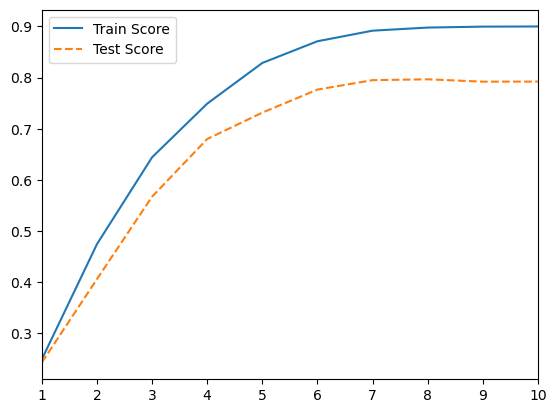

In [88]:
plt.plot(para_depth,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_depth,test_score,linestyle = "--",label = "Test Score")
plt.legend()

최대 깊이 증가에 따라 test와 train 모델의 설명령은 증가하는 모양을 보인다.

Train/Test 데이터의 성능 변화를 고려했을 때 4에서 test그래프가 약간 기울기가 감소하고 6 이후로는 직선적으로 모양이 변하지 않는다.

=> max_depth가 4일 때와 6일 때를 비교해서 결정하기로 한다

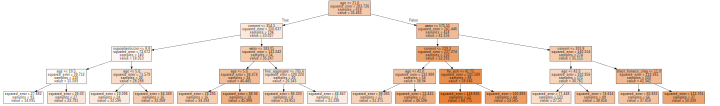

In [89]:
# 최대 깊이 = 4 모델
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=8,min_samples_split=16,max_depth=4)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_depth.dot",
               feature_names= v_feature_name, impurity=True,filled=True)
with open("tree_depth.dot") as f:
    dot_graph = f.read()

fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

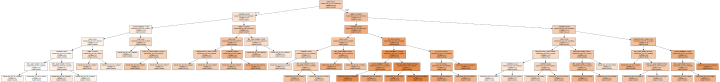

In [9]:
# 최대 깊이 6 모델
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=8,min_samples_split=16,max_depth=6)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_depth.dot",
               feature_names= v_feature_name, impurity=True,filled=True)
with open("tree_depth.dot") as f:
    dot_graph = f.read()

fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

max_depth 가 4일 경우에는 좌우가 balanced된 모양을 보이지만 max_depth는 우측으로 심하게 치우쳐져 있으며 약간 overfitting인 것 같은 모습을 보인다

=> 두 그래프를 비교했을 때 max_depth는 4로 선택한다

### 최종 모델 선정

In [13]:
tree_final = DecisionTreeRegressor(min_samples_leaf=8,min_samples_split=16,max_depth=4, random_state=1234,)
tree_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.749
Score on test set: 0.680


최종 모델 시각화

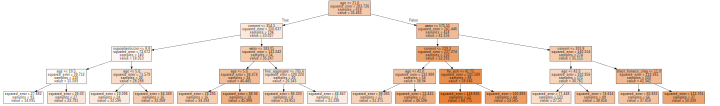

In [92]:
export_graphviz(tree_final, out_file = "tree_final.dot",
               feature_names= v_feature_name, impurity=True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()

fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

In [93]:
src = graphviz.Source(dot_graph)
src.view()

'Source.gv.pdf'

결론추가

트리 분리에 영향이 큰 변수는 : age, cement, water 이다

age < 21 이면 True,(자료 수 = 618, value가 35에서 23로 감소하고 mse감소된다

(이후 분리 조건의 좌측이 True, 우측이 False로 적용됨)

최대 깊이가 증가하면서 생성되는 잎사귀의 자료수는 감소하고 모델의 mse또한 지속적으로 감소하지만,

분리 조건에 따라 x는 상위 노드 대비 증가하거나 감소한다.

### 결론 도출

feature_importances_ : 설명변수의 중요도

In [94]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
7,age,0.416
0,cement,0.264
3,water,0.234
4,superplasticizer,0.029
1,blast_furnace_slag,0.028
2,fly_ash,0.023
6,fine_aggregate,0.006
5,coarse_aggregate,0.000


Text(0, 0.5, '변수')

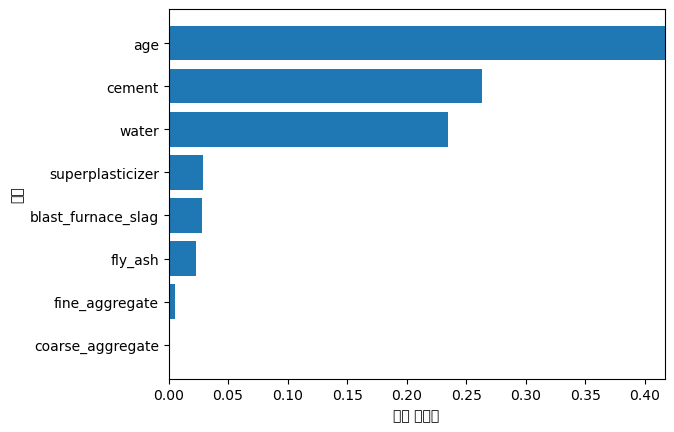

In [95]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

중요 설명변수 : age, cement, water 순으로 영향이 크다고 해석할 수 있다.

단 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있다.

- 모델 parameter 조정, 추가

GridSearchCV를 이용한 최적 Parameter 찾기

In [96]:
estimator = DecisionTreeRegressor()

# 구하고자 하는 parameter와 범위
param_grid = {"criterion" : ["mse","friedman_mse","mae"], "max_features":[1.0],
             "max_depth": para_depth, "min_samples_split": para_split, "min_samples_leaf":para_leaf}

# 설명력이 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs= -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(criterion='friedman_mse', max_depth=9, max_features=1.0,
                      min_samples_leaf=3, min_samples_split=8)

best parameter: 
{'criterion': 'friedman_mse', 'max_depth': 9, 'max_features': 1.0, 'min_samples_leaf': 3, 'min_samples_split': 8}

best score: 
0.792


best estimator model: 

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4)

best parameter: 

{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 4}

best score: 
0.789
                      
최대 깊이(max_depth)가 10, 잎사귀의 최소 샘플 수가 3, 분리 노드의 최소 자료수가 4일 때 설명력 78.9%

GridSearchCV는 fit을 이용하여 데이터를 적합시킬 때 train/validation 데이터로 나누어 cross-validation을 적용하므로 앞선 결과와 다를 수 있다.

+ 직접 선택한 값들은 (min_samples_leaf=8,min_samples_split=16,max_depth=4)이다

+ 참고 : best estimator model에서 auto는 모델 생성 시 사용하는 설명변수의 수를 지정할 때 sqrt(전체 변수의 수)값 만큼 변수를 임의로 선택하겠다는 뜻이다

---------------

# 랜덤 포레스트

In [97]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength",axis = 1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.4,
                                                                random_state=1234)
print("train dzta X size : {}".format(df_train_x.shape))
print("train dzta Y size : {}".format(df_train_y.shape))
print("test dzta X size : {}".format(df_test_x.shape))
print("test dzta Y size : {}".format(df_test_y.shape))

train dzta X size : (618, 8)
train dzta Y size : (618,)
test dzta X size : (412, 8)
test dzta Y size : (412,)


## 모델 생성

In [98]:
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.980
Score on test set: 0.904


모델 설명력은 trian 0.98, test 0.90으로 모델은 train 데이터에 아주 조금 더 잘맞는 모습을 보인다

* n_estimators : 트리 수 변경에 따른 모델 성능

In [59]:
train_score = []
test_score = []

# n_estimators : 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators=v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["n_estimators"] = para_n_tree
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.973,0.905
1,20,0.978,0.905
2,30,0.979,0.903
3,40,0.979,0.905
4,50,0.980,0.905
5,60,0.980,0.906
6,70,0.980,0.906
7,80,0.980,0.906
8,90,0.980,0.905
9,100,0.980,0.904


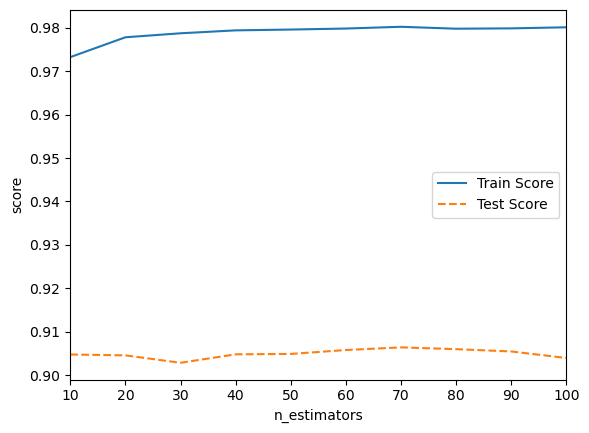

In [64]:
plt.plot(para_n_tree,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_n_tree,test_score,linestyle = "--",label = "Test Score")
plt.ylabel('score');plt.xlabel("n_estimators")
plt.legend()

생성하는 결정 트리 수 증가에 따라 모델의 설명력은 증가하지만 트리수가 20개를 초과해도 설명력은 거의 향상되지 않음

최대 트리 수에 따른 영향을 배제하고 다른 파라미터의 영향을 확인하고자 100 선택

* min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [65]:
train_score = []
test_score = []

# min_sample_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state = 1234, n_estimators=100,
                              min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_leaf
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.980,0.904
1,2,0.967,0.900
2,3,0.953,0.893
3,4,0.939,0.882
4,5,0.926,0.872
5,6,0.915,0.862
6,7,0.904,0.854
7,8,0.896,0.848
8,9,0.888,0.838
9,10,0.878,0.827


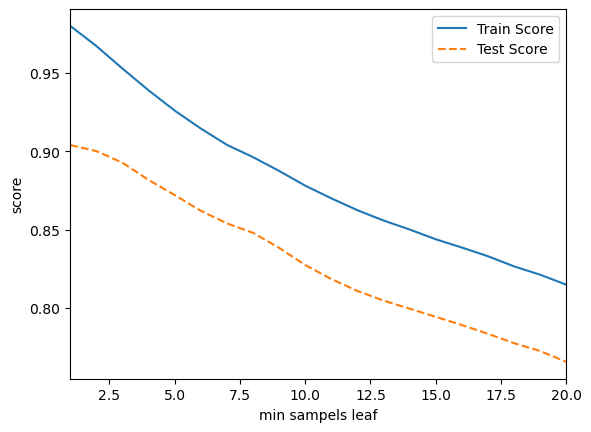

In [66]:
plt.plot(para_leaf,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_leaf,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("min sampels leaf")
plt.legend()

잎사귀 노드의 최소 자료 수가 증가함에 따라 train, test score가 모두 급격하게 하락하는 형상을 보인다.

test 데이터의 정확도가 너무 낮아지면 안되기 때문에 6을 선택하기 한다.

=> min samples leaf = 6으로 결정

* min_samples_split : 분리 노드의 최소 자료 수 변경

In [100]:
train_score = []
test_score = []

# min_sample_split : 분할하기 위한 노드의 최소자료 수
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state = 1234, n_estimators=100,
                              min_samples_leaf=6, min_samples_split= v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.915,0.862
1,6,0.915,0.862
2,8,0.915,0.862
3,10,0.915,0.862
4,12,0.915,0.862
5,14,0.910,0.858
6,16,0.904,0.854
7,18,0.899,0.849
8,20,0.893,0.843
9,22,0.887,0.836


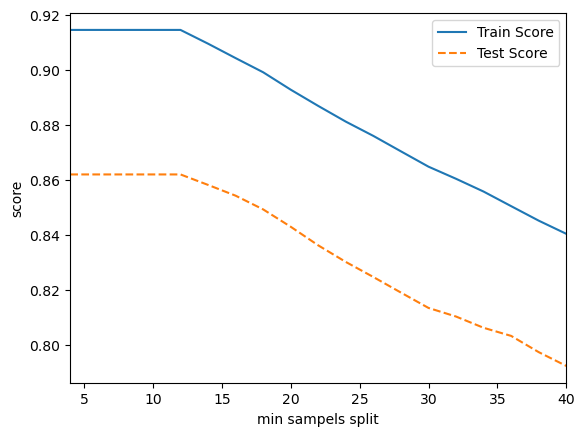

In [101]:
# 모델의 설명력 확인
plt.plot(para_split,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_split,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("min sampels split")
plt.legend()

분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소한다. 

min sampls split이 10인 지점에서 test와 train모두 score가 급격하게 감소한다

=> min samples spilt은 10으로 결정

* max_depth : 최대 깊이 변경에 따른 모델 성능

In [102]:
train_score = []
test_score = []

# max_depth : 최대 깊이 변경
para_leaf = [n_leaf for n_leaf in range(1,11)]

for v_max_depth in para_leaf:
    rf = RandomForestRegressor(random_state = 1234, n_estimators=100,
                              min_samples_leaf=6, min_samples_split = 10,
                              max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["Depth"] = para_depth
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,Depth,TrainScore,TestScore
0,1,0.337,0.329
1,2,0.619,0.595
2,3,0.742,0.699
3,4,0.817,0.775
4,5,0.873,0.828
5,6,0.898,0.851
6,7,0.908,0.859
7,8,0.912,0.861
8,9,0.914,0.862
9,10,0.914,0.862


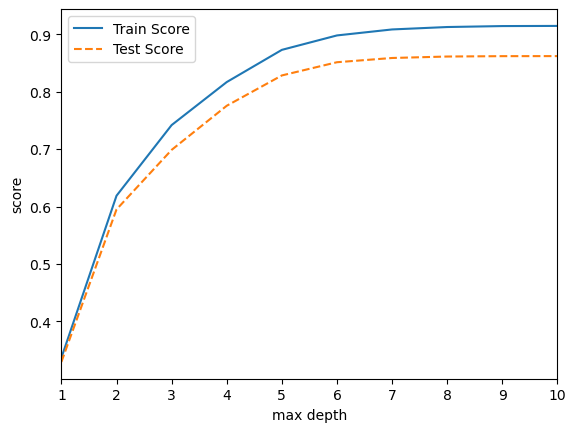

In [104]:
plt.plot(para_depth,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_depth,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

최대 깊이 증가에 따라 모델의 설명력은 증가한다. 

하지만 5 이후에 test와 train모두 비교적 직선적인 경향을 보이고 있고 폭도 비슷하게 유지된다

=> 최대깊이 depth는 5로 결정

## 최종 모델 생성

In [105]:
rf_final = RandomForestRegressor(random_state=1234, n_estimators=100, min_samples_leaf=6,
                                min_samples_split=10, max_depth=5)

rf_final.fit(df_train_x, df_train_y)

# train 데이터의 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x,df_train_y)))

# test 데이터의 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x,df_test_y)))

rf_final

Score on training set: 0.873
Score on test set: 0.828


RandomForestRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=10,
                      random_state=1234)

train score는 0.87이고 test score는 0.82로 처음에 train데이터에 대한 과대적합이 없어진 것을 확인할 수 있다

- 최종 모델 시각화 : graphviz 활용

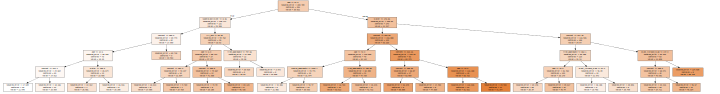

In [106]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 0번 트리
export_graphviz(rf_final.estimators_[0], out_file="rfr_final_0.dot", feature_names=v_feature_name,\
               impurity = True, filled=True)

#tree_final_0.dot그리기
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

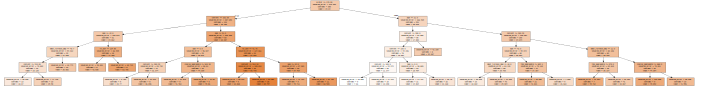

In [107]:
# 1번 트리
export_graphviz(rf_final.estimators_[1], out_file="rfr_final_1.dot", feature_names=v_feature_name,\
               impurity = True, filled=True)

#tree_final_0.dot그리기
with open("rfr_final_1.dot") as f:
    dot_graph = f.read()
fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

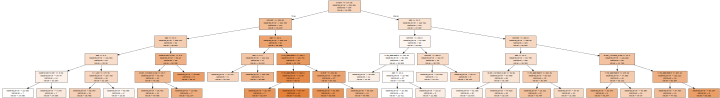

In [108]:
# 10번 트리
export_graphviz(rf_final.estimators_[10], out_file="rfr_final_10.dot", feature_names=v_feature_name,\
               impurity = True, filled=True)

#tree_final_0.dot그리기
with open("rfr_final_10.dot") as f:
    dot_graph = f.read()
fixed_dot_graph = "digraph Tree {\nsize=\"10,10\";\n" + dot_graph.split('{', 1)[1]
display(graphviz.Source(fixed_dot_graph))

위와 같은 트리 100개(n_estimators = 100)를 조합하여 최종 모델이 생성된다

### 결론 도출

feature_importances_ : 설명변수의 중요도

In [109]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
7,age,0.391
0,cement,0.279
3,water,0.153
4,superplasticizer,0.082
1,blast_furnace_slag,0.039
6,fine_aggregate,0.030
2,fly_ash,0.014
5,coarse_aggregate,0.013


Text(0, 0.5, '변수')

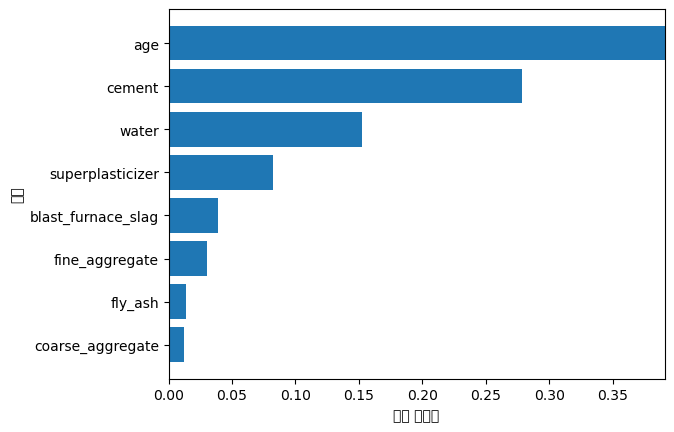

In [110]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

중요 설명 변후 : age, cement, water순으로 영향이 크다고 해석할 수 있음

단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

* GridSearchCV를 이용한 최적 parameter 찾기

In [112]:
 ### estimator = RandomForestRegressor(random_state=1234)

# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": para_depth, "min_samples_split":para_split, "min_samples_leaf" : para_leaf}

# 설명력이 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs= -1)
grid_rf.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=6)

best parameter: 
{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 6}

best score: 
0.797


best parameter: 
{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 6}

best score: 
0.797

따라서 GridSearchCV를 통해서 얻은 최종 모델에서 max_depth는 10, min_samples_leaf는 3, min_samples_split은 6이 나온다

이 값은 이전에 고른  

rf_final = RandomForestRegressor(random_state=1234, n_estimators=100, min_samples_leaf=6,min_samples_split=10, max_depth=5)

max_depth는 5, min_samples_leaf는 6, min_samples_split은 10과 다른 값이 나온다.

------------

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import pydotplus

# 그래디언트 부스팅

In [20]:
df_raw = pd.read_csv("Concrete.csv", encoding = 'euc-kr')
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [21]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength",axis = 1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.4,
                                                                random_state=1234)
print("train dzta X size : {}".format(df_train_x.shape))
print("train dzta Y size : {}".format(df_train_y.shape))
print("test dzta X size : {}".format(df_test_x.shape))
print("test dzta Y size : {}".format(df_test_y.shape))

train dzta X size : (618, 8)
train dzta Y size : (618,)
test dzta X size : (412, 8)
test dzta Y size : (412,)


In [28]:
# 모델 생성 : GradientboostingRegressor
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.951
Score on test set: 0.915


* n_estimators  : 생성될 트리의 최대 개수 지정

트리 개수를 감소시키면 일반적으로 과대적합 방지 - 이전 모델을 학습하면서 점진적으로 오차를 보완

In [6]:
train_score = []
test_score = []

# n_estimators : 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["n_estimators"] = para_n_tree
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.646,0.621
1,20,0.807,0.773
2,30,0.870,0.835
3,40,0.898,0.863
4,50,0.915,0.878
5,60,0.925,0.888
6,70,0.934,0.898
7,80,0.940,0.904
8,90,0.946,0.910
9,100,0.951,0.915


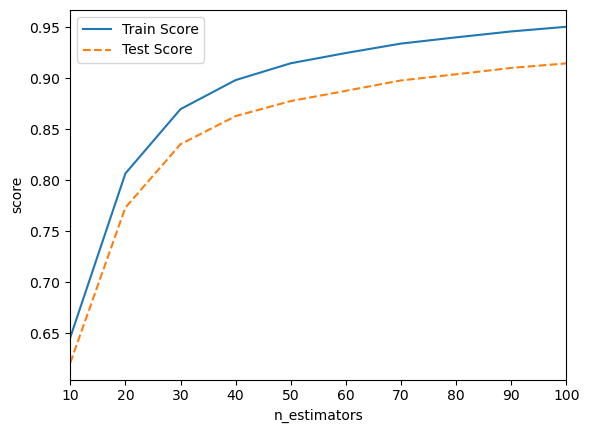

In [119]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_n_tree,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

n_estimator 즉 생성될 트리의 최대개수가 증가함에 따라 test, train모두 증가하는 양상을 보인다.

n_estimator가 20일 때 기울기가 조금 변화하고 또 30일 때도 약간 변화한다

하지만 전체적으로 보았을 때 그래프가 30을 기점으로 그 이전과 그 이후의 모양이 다르므로

=> n_estimator를 30으로 결정

* min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [26]:
train_score = []
test_score = []

# min_sample_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators=30,
                              min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_leaf
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.870,0.835
1,2,0.869,0.832
2,3,0.868,0.833
3,4,0.868,0.835
4,5,0.867,0.836
5,6,0.866,0.836
6,7,0.867,0.838
7,8,0.867,0.838
8,9,0.865,0.835
9,10,0.864,0.835


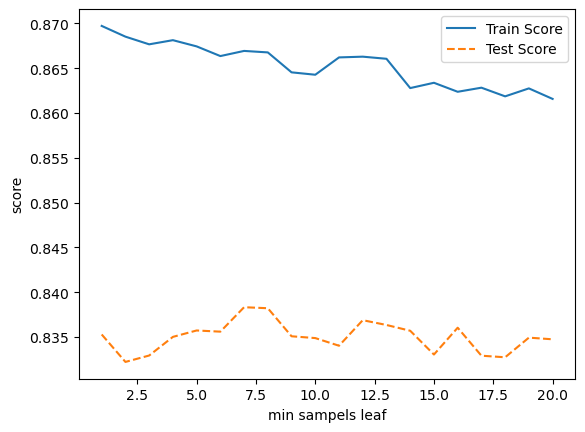

In [6]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_leaf,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("min sampels leaf")
plt.legend()

min_samples_leaf가 7일 때 가장 test score값이 높아지면서 train score와 test score 사이의 gap도 소량 줄어든다

=> min_samples_leaf는 7로 정하기로 한다

* min_samples_split : 분리 노드의 최소 자료 수에 따른 모델 성능

In [25]:
train_score = []
test_score = []

# min_sample_split : 분할하기 위한 노드의 최소자료 수
para_split = [n_leaf * 2 for n_leaf in range(1,21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators=30,
                              min_samples_leaf=7, min_samples_split= v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.867,0.838
1,4,0.867,0.838
2,6,0.867,0.838
3,8,0.867,0.838
4,10,0.867,0.838
5,12,0.867,0.838
6,14,0.867,0.838
7,16,0.867,0.838
8,18,0.867,0.838
9,20,0.867,0.838


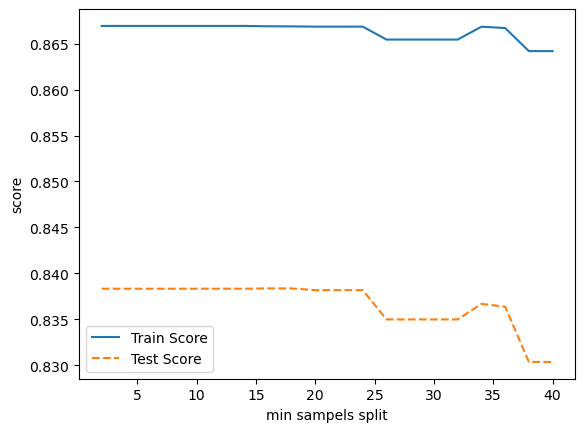

In [8]:
# 모델 설명력 그래프 확인
plt.plot(para_split,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_split,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("min sampels split")
plt.legend()

min samples split이 24일 때 train이 0.867 test가 0.838 로 그 중 가장 gap이 작다
=> min samples split 을 24로 결정한다

* max_depth : 최대 깊이 변경에 따른 모델 성능

In [24]:
train_score = []
test_score = []

# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators=30,
                              min_samples_leaf=7, min_samples_split = 24,
                              max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["Depth"] = para_depth
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,Depth,TrainScore,TestScore
0,1,0.606,0.579
1,2,0.795,0.762
2,3,0.867,0.838
3,4,0.915,0.878
4,5,0.940,0.890
5,6,0.953,0.907
6,7,0.958,0.908
7,8,0.962,0.910
8,9,0.965,0.913
9,10,0.964,0.910


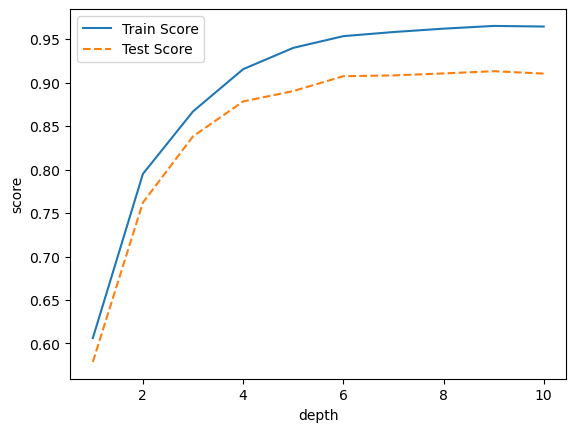

In [10]:
# 모델 설명력 그래프 확인
plt.plot(para_depth,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_depth,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("depth")
plt.legend()

depth가 증가함에 따라 train score와 test score가 모두 증가하는 양상을 보인다.

하지만 depth가 4일 때 train score와 test score의 gap이 유의미하게 줄어드는 동시에 score값이 높아진다

=> depth는 4로 결정한다


* learning rate : 학습률 변경에 따른 모델 성능

이전 모델에 대한 학습률로, 이전 모델을 얼마나 학습할지 결정한다.

In [23]:
train_score = []
test_score = []

# learning rate : 학습률 변경 0.1~0.9
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators=30,
                              min_samples_leaf=7, min_samples_split = 24,
                              max_depth = 4, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["LearningRate"] = para_lr
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.915,0.878
1,0.2,0.944,0.903
2,0.3,0.959,0.911
3,0.4,0.962,0.909
4,0.5,0.970,0.913
5,0.6,0.968,0.898
6,0.7,0.973,0.890
7,0.8,0.973,0.878
8,0.9,0.970,0.885


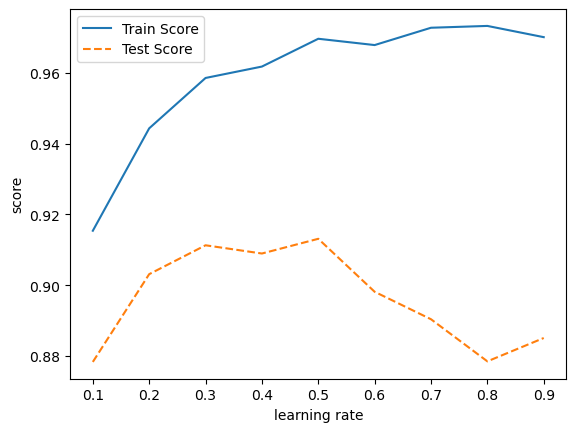

In [12]:
# 모델 설명력 그래프 확인
plt.plot(para_lr,train_score,linestyle = "-",label = "Train Score")
plt.plot(para_lr,test_score,linestyle = "--",label = "Test Score")
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

learning rate가 0.5를 넘어가면 test score가 급격하게 줄어든다.

learning rate가 0.3에서도 test score가 약간 솟아 있고 0.5에도 그러하지만,

learning rate가 0.5일 대는 train과 test 사이의 gap이 크고, 학습률이 높을수록 과대적합 경향을 보일 수 있으므로 

=> learning rate는 0.3으로 결정

#### 최종 모델 생성

In [13]:
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=7,
                                min_samples_split=24, max_depth=4, learning_rate=0.3)

gb_final.fit(df_train_x, df_train_y)

# train 데이터의 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x,df_train_y)))

# test 데이터의 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x,df_test_y)))


Score on training set: 0.959
Score on test set: 0.911


기본 옵션보다 과적합이 약간 해소된 것을 확인할 수 있다

최종 결론 도출

feature_importances_ : 설명변수의 중요도

In [14]:
#변수명 저장
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
7,age,0.351
0,cement,0.282
3,water,0.147
4,superplasticizer,0.083
1,blast_furnace_slag,0.063
6,fine_aggregate,0.041
5,coarse_aggregate,0.020
2,fly_ash,0.013


Text(0, 0.5, '변수')

/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4832

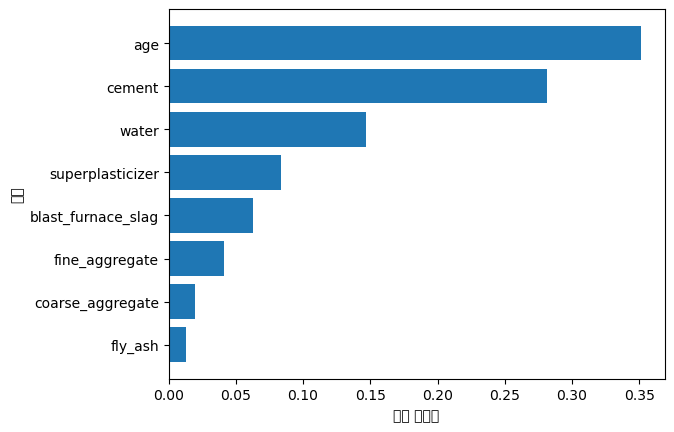

In [15]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

중요 설명 변수는 age, cement, water 순으로 영향이 크다고 해석할 수 있다.

모델 parameter 조정 - 추가

- GridSearchCV를 이용한 최적 parameter 찾기

In [27]:
estimator = GradientBoostingRegressor(random_state=1234)

param_grid = {"criterion" : ['mse','friedman_mse', 'mae'],
             "max_features": [1.0],
             'learning_rate': para_lr,
             'max_depth' : para_depth,
             'min_samples_leaf': para_leaf}

grid_gb = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1)
grid_gb.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

best estimator model: 
GradientBoostingRegressor(learning_rate=0.30000000000000004, max_depth=10,
                          max_features=1.0, min_samples_leaf=9,
                          random_state=1234)

best parameter: 
{'criterion': 'friedman_mse', 'learning_rate': 0.30000000000000004, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 9}

best score: 
0.903


best parameter: 
{'criterion': 'friedman_mse', 'learning_rate': 0.30000000000000004, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 9}

best score: 
0.903


전에 직접 만든 모델의 경우 다음과 같고
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=7, min_samples_split=24, max_depth=4, learning_rate=0.3고

결과는
Score on training set: 0.959
/ Score on test set: 0.911

직접 만든 모델과 차이가 있다